In [1]:
import os
import ase
from ase import Atoms
import numpy as np
import tqdm
import ase.io
from nice.transformers import *
from nice.rascal_coefficients import get_rascal_coefficients_parallelized
from nice.utilities import make_structural_features
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge

In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/pozdn/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
PROPERTIES_NAMES = ['tag', 'index', 'A', 'B', 'C', 'mu',
                    'alpha', 'homo', 'lumo', 'gap', 'r2',
                    'zpve', 'U0', 'U', 'H', 'G', 'Cv']


def string_to_float(element):
    '''because shit like 2.1997*^-6 happens'''
    return float(element.replace('*^', 'e'))

PROPERTIES_HANDLERS = [str, int] + [string_to_float] * (len(PROPERTIES_NAMES) - 2)

def parse_qm9_xyz(path):
    with open(path, 'r') as f:
        lines = list(f)
    #print(lines)
    n_atoms = int(lines[0])
    properties = {name:handler(value)
                  for handler, name, value in zip(PROPERTIES_HANDLERS,
                                            PROPERTIES_NAMES,
                                            lines[1].strip().split())}
    composition = ""
    positions = []
    for i in range(2, 2 + n_atoms):
        composition += lines[i].strip().split()[0]
        positions.append([string_to_float(value) 
                          for value in lines[i].strip().split()[1:4]])
        
    
    positions = np.array(positions)
    result = Atoms(composition, positions = np.array(positions))
    result.info.update(properties)
    return result

def parse_index(path):
    with open(path, "r") as f:
        lines = list(f)
    proper_lines = lines[9:-1]
    result = [int(line.strip().split()[0]) for line in proper_lines]
    return np.array(result, dtype = int)

def download_qm9(clean = True):
    #downloading from https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904
    os.system("wget https://ndownloader.figshare.com/files/3195389 -O qm9_main.xyz.tar.bz2")
    os.system("wget https://ndownloader.figshare.com/files/3195404 -O problematic_index.txt")
    os.system("mkdir qm9_main_structures")
    os.system("tar xjf qm9_main.xyz.tar.bz2 -C qm9_main_structures")
    
    names = [name for name in os.listdir('qm9_main_structures/') if name.endswith('.xyz')]
    names = sorted(names)
    
    structures = [parse_qm9_xyz('qm9_main_structures/{}'.format(name))
              for name in tqdm.tqdm(names)]
    
    problematic_index = parse_index('problematic_index.txt')
    np.save('problematic_index.npy', problematic_index)
    ase.io.write('qm9_main.extxyz', structures)
    if (clean):
        os.system("rm -r qm9_main_structures")
        os.system("rm problematic_index.txt")
        os.system("rm qm9_main.xyz.tar.bz2")
    return structures, problematic_index
              
def get_qm9(clean = True):
    if ('qm9_main.extxyz' in os.listdir('.')) and \
              ('problematic_index.npy' in os.listdir('.')):
        structures = ase.io.read('qm9_main.extxyz', index = ':')
        problematic_index = np.load('problematic_index.npy')
        return structures, problematic_index
    else:
        return download_qm9(clean = clean)
              

In [3]:
structures, problematic_index = get_qm9()

In [4]:
HARTREE_TO_EV = 27.211386245988
USE_PROBLEMATIC_INDEX = False
np.random.seed(0)

if (not USE_PROBLEMATIC_INDEX):
    structures = [structure for structure in structures
                if structure.info['index'] not in problematic_index]
    
del problematic_index #it borrows indexing from 1 from qm9, deleting it away from sin
 
permutation = np.random.permutation(len(structures))
print(len(structures))
train_indices = permutation[0:100000]  
test_indices = permutation[100000:]     
environments_for_fitting = 5000    #number of environments to fit nice transfomers
grid =  [150, 200, 350, 500, 750, 1000,
         1500, 2000, 3500, 5000, 7500, 10000,
         15000, 20000, 35000, 50000, 75000, 100000] #for learning curve

#HYPERS for librascal spherical expansion coefficients
HYPERS = {'interaction_cutoff': 5.0,
          'max_radial': 5, 
          'max_angular': 5, 
          'gaussian_sigma_constant': 0.3,
          'gaussian_sigma_type': 'Constant',
          'cutoff_smooth_width': 0.5, 
          'radial_basis': 'GTO', 
          'cutoff_function_type': 'RadialScaling',
          'cutoff_function_parameters': 
          {'rate': 2, 'scale': 1, 'exponent': 6, 'interaction_cutoff': 5.0, 'cutoff_smooth_width': 0.5}, 
         }

130831


In [5]:
#our model:
def get_transformer():
    return StandardSequence([StandardBlock(ThresholdExpansioner(num_expand = 5000),
                                              CovariantsPurifierBoth(max_take = 100),
                                                  IndividualLambdaPCAsBoth(2000),
                                                  ThresholdExpansioner(num_expand = 50000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                 InvariantsPCA(n_components = 1500)),                             
                             StandardBlock(None,
                                           None,
                                           None,
                                                  ThresholdExpansioner(num_expand = 50000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 100),
                                                 InvariantsPCA(n_components = 1500))
                            ],
                            initial_scaler = InitialScaler(mode = 'signal integral',
                                                           individually = True)
                          )

In [6]:
train_structures = [structures[i] for i in train_indices]
train_coefficients = get_rascal_coefficients_parallelized(train_structures, HYPERS)
test_structures = [structures[i] for i in test_indices]
test_coefficients = get_rascal_coefficients_parallelized(test_structures, HYPERS)

100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


In [7]:
all_species = []
for structure in train_structures:
    all_species.append(np.array(structure.get_atomic_numbers()))
all_species = np.concatenate(all_species, axis=0)
all_species = np.sort(np.unique(all_species))


In [8]:
print(all_species)

[1 6 7 8 9]


In [9]:
all_coefficients = [train_coefficients[key] for key in train_coefficients.keys()]
all_coefficients = np.concatenate(all_coefficients, axis = 0)
np.random.shuffle(all_coefficients)
all_coefficients = all_coefficients[0:environments_for_fitting]

In [10]:
transformer = get_transformer()
transformer.fit(all_coefficients)

/home/pozdn/.local/lib/python3.6/site-packages/nice/transformers/compressors.py:107: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 20000, while number of vectors is 5000, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 5000. Number of pca components is 2000.
  RuntimeWarning,
/home/pozdn/.local/lib/python3.6/site-packages/nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 1500, desired number of environments is 15000, actual number of environments is 5000.
  self.n_components, num_fit_now, X.shape[0]))
/home/pozdn/.local/lib/python3.6/site-packages/nice/transformers/compressors.py:201: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 1500, desired number of environments is 15000, actual number of environments is 5000.
  self.n_components, num_f

In [11]:
def transform_sequentially(transformer, structures, all_species, 
                           block_size = 500, show_progress = True):
    pieces = []
    
    for i in tqdm.tqdm(range(0, len(structures), block_size), disable = not show_progress):
        now = {}
        coefficients = get_rascal_coefficients_parallelized(structures[i : i + block_size],
                                                            HYPERS,
                                                            show_progress = False)
        for specie in all_species:
            now[specie] = transformer.transform(coefficients[specie],
                                                      return_only_invariants = True)
        pieces.append(make_structural_features(now, structures[i : i + block_size],
                                               show_progress = False))        
    
    return np.concatenate(pieces, axis = 0)

In [12]:
train_features = transform_sequentially(transformer, 
                                        train_structures, all_species)
test_features = transform_sequentially(transformer,
                                        test_structures, all_species)

100%|██████████| 62/62 [2:20:21<00:00, 135.83s/it]  


In [13]:
def get_compositional_features(structures, all_species):
    result = np.zeros([len(structures), len(all_species)])
    for i, structure in tqdm.tqdm(enumerate(structures)):
        species_now = structure.get_atomic_numbers()
        for j, specie in enumerate(all_species):
            num = np.sum(species_now == specie)
            result[i, j] = num
    return result

In [14]:
train_c_features = get_compositional_features(train_structures, all_species)
test_c_features = get_compositional_features(test_structures, all_species)

train_features = np.concatenate([train_features, train_c_features], axis = 1)
test_features = np.concatenate([test_features, test_c_features], axis = 1)


100000it [00:03, 27886.37it/s]
30831it [00:01, 28380.64it/s]


In [15]:
del train_coefficients
del test_coefficients
del all_coefficients
del transformer

In [16]:
train_energies = [structure.info['U0'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['U0'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV


In [17]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second) ** 2))
def get_mae(first, second):
    return np.mean(np.abs(first - second))

def estimate_performance(clf, data_train, data_test, targets_train, targets_test):
    clf.fit(data_train, targets_train)
    predictions = clf.predict(data_test)
    return get_rmse(predictions, targets_test), get_mae(predictions, targets_test)

In [18]:
from sklearn.linear_model import Ridge

def get_performance(alpha):
    
    errors_compositional = []
    for el in tqdm.tqdm(grid):   
        errors_compositional.append(estimate_performance(Ridge(alpha = alpha), train_c_features[:el],
                                           test_c_features, train_energies[:el],
                                           test_energies))

    errors_compositional = np.array(errors_compositional)
    errors_nice = []
    for el in tqdm.tqdm(grid):
        # because without this step with residuals
        # joint fitting might face problems due to
        # regularization
        clf = Ridge(alpha = alpha)
        clf.fit(train_c_features[:el], train_energies[:el])

        residuals_train = train_energies[:el] - clf.predict(train_c_features[:el])
        residuals_test = test_energies - clf.predict(test_c_features)

        errors_nice.append(estimate_performance(Ridge(alpha = alpha), train_features[:el],
                                           test_features, residuals_train,
                                           residuals_test))

    errors_nice = np.array(errors_nice)
    
    print("alpha: ", alpha)
    print("rmse: ", errors_nice[-1][0], " eV")
    print("mae: ", errors_nice[-1][1], " eV")
    
    fig, axes = plt.subplots(1, 2)


    axes[0].plot(grid, errors_compositional[:, 0], 'ro')
    axes[0].plot(grid, errors_compositional[:, 0], 'r', label = 'only compositional')

    axes[0].plot(grid, errors_nice[:, 0], 'bo')
    axes[0].plot(grid, errors_nice[:, 0], 'b', label = 'nice')

    axes[0].set_xlabel("n_train")
    axes[0].set_ylabel("rmse, eV")
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')

    axes[1].plot(grid, errors_compositional[:, 1], 'ro')
    axes[1].plot(grid, errors_compositional[:, 1], 'r', label = 'only compositional')

    axes[1].plot(grid, errors_nice[:, 1], 'bo')
    axes[1].plot(grid, errors_nice[:, 1], 'b', label = 'nice')

    axes[1].set_xlabel("n_train")
    axes[1].set_ylabel("mae, eV")
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    plt.legend(loc = 'upper center')
    plt.subplots_adjust(wspace = 0.4)
    plt.show()


100%|██████████| 18/18 [04:38<00:00, 15.50s/it]


alpha:  0.0001
rmse:  0.06797606195131219  eV
mae:  0.03318744925644689  eV


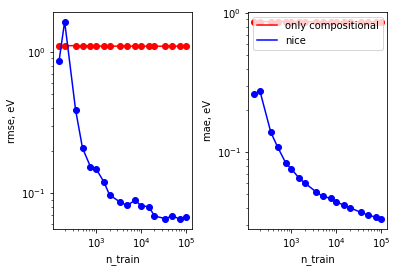

In [19]:
get_performance(1e-4)

 56%|█████▌    | 10/18 [00:11<00:13,  1.68s/it]/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.06091e-16): result may not be accurate.
  overwrite_a=False)
 61%|██████    | 11/18 [00:16<00:19,  2.76s/it]/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.32996e-17): result may not be accurate.
  overwrite_a=False)
 67%|██████▋   | 12/18 [00:25<00:27,  4.57s/it]/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.77332e-17): result may not be accurate.
  overwrite_a=False)
 72%|███████▏  | 13/18 [00:49<00:52, 10.49s/it]/home/pozdn/.local/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.124e-17): result may not be accurate.
  overwrite_a=True).T
 78%|███████▊  | 14/18 [01:15<01:00, 15.04s/it]/h

alpha:  1e-09
rmse:  0.08860157404628088  eV
mae:  0.017707561471739675  eV


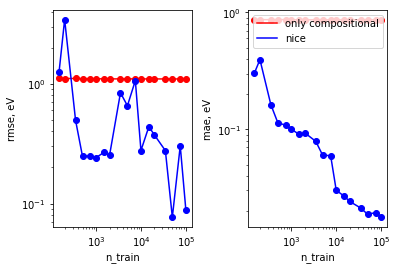

In [20]:
get_performance(1e-9)